In [48]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch #for using tensors
import torch.nn as nn # creating neural network
import torch.nn.functional as F # recallable functions like relu,sigmoid and etc.
import torchvision # subpackage for vision models
import torchvision.transforms as transforms # image augmentation
import torch.optim as optim # optimisation functions like sgd, adam
from torch.utils.data import DataLoader # creating a data loader
from torchvision.transforms import ToTensor # converting image to tensor
import matplotlib.pyplot as plt 

In [49]:
#Some of the files inside the seg_train and seg_test directories have been modified. That is because seg_train didn't
#have anything inside the files 'mountain', 'sea', 'street'. Some of the images from those files from seg_test have been
#moved to seg_train manually.

#Also a subfolder containing unlabeled images was created in seg_pred so that the data can be loaded.
train_path = 'drive/MyDrive/cnn/seg_train'
test_path = 'drive/MyDrive/cnn/seg_test'
pred_path = 'drive/MyDrive/cnn/seg_pred'

#Normalizing and Prepocessing the data
transform = transforms.Compose([
    transforms.Resize((150, 150)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dummy_label = 0
def get_label(path):
    return dummy_label

training_data = ImageFolder(root=train_path, transform=transform)
testing_data = ImageFolder(root=test_path, transform=transform)
prediction_data = ImageFolder(root=pred_path, transform=transform)

In [ ]:
#Getting the info about the training data
training_data

Dataset ImageFolder
    Number of datapoints: 5717
    Root location: drive/MyDrive/cnn/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
#Getting the info about the testing data
testing_data

Dataset ImageFolder
    Number of datapoints: 2042
    Root location: drive/MyDrive/cnn/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
#Getting the info about the prediction data
prediction_data

Dataset ImageFolder
    Number of datapoints: 7324
    Root location: drive/MyDrive/cnn/seg_pred
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
#This is an example of pixel data for the second image in the dataset
training_data[1][0]

tensor([[[-0.4667, -0.4588, -0.4431,  ...,  0.7333,  0.7176,  0.6941],
         [-0.4275, -0.4275, -0.4353,  ...,  0.8118,  0.7882,  0.7725],
         [-0.3961, -0.4039, -0.4275,  ...,  0.8745,  0.8431,  0.8196],
         ...,
         [-0.7255, -0.6157, -0.6941,  ..., -0.5686, -0.5137, -0.5137],
         [-0.8275, -0.6941, -0.6941,  ..., -0.3725, -0.4353, -0.5529],
         [-0.5373, -0.9059, -0.6941,  ..., -0.7647, -0.4275, -0.4196]],

        [[-0.0510, -0.0353, -0.0510,  ...,  0.7569,  0.7412,  0.7176],
         [-0.0353, -0.0353, -0.0431,  ...,  0.8353,  0.8118,  0.7961],
         [-0.0353, -0.0431, -0.0431,  ...,  0.8824,  0.8667,  0.8431],
         ...,
         [-0.7176, -0.6078, -0.6627,  ..., -0.6706, -0.6392, -0.6392],
         [-0.8196, -0.6863, -0.6706,  ..., -0.4745, -0.5608, -0.6784],
         [-0.5373, -0.8824, -0.6706,  ..., -0.8667, -0.5529, -0.5451]],

        [[ 0.4667,  0.4667,  0.4431,  ...,  0.8275,  0.8118,  0.7882],
         [ 0.4431,  0.4431,  0.4353,  ...,  0

In [ ]:
#We can see that the images are colored due to the shape being 3, 150, 150. This means that we are passing in all
#of the info about RGB.
training_data[1][0].size()

torch.Size([3, 150, 150])

In [ ]:
#For this particular row the label is 0. This stands for "buildings"
training_data[1][1]

0

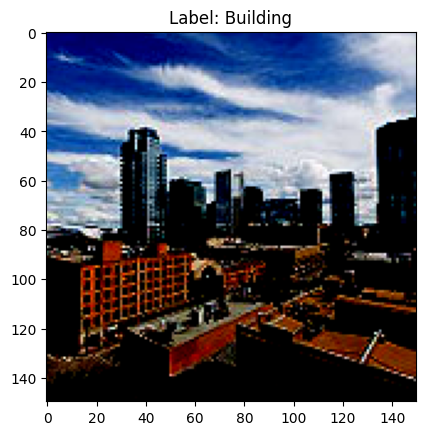

In [ ]:
#Showing the image itself
image, label = training_data[1]
plt.imshow(image.permute(1, 2, 0))
plt.title(f'Label: Building')
plt.show()

In [ ]:
#Writing the label meanings:
'''{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }'''

"{'buildings' -> 0,\n'forest' -> 1,\n'glacier' -> 2,\n'mountain' -> 3,\n'sea' -> 4,\n'street' -> 5 }"

In [50]:
batch_size = 16

In [ ]:
#Creating the train_loader and test_loader
train_loader = DataLoader(training_data,shuffle=True,batch_size=batch_size)
test_loader = DataLoader(testing_data,shuffle=True)

In [ ]:
#Visualizing a batch of data
for x,y in train_loader:
    print(x.shape)
    print(y)
    break

torch.Size([16, 3, 150, 150])
tensor([1, 1, 0, 1, 0, 0, 0, 1, 4, 0, 3, 1, 4, 1, 3, 0])


In [ ]:
#Creating the model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #Choosing 3 input channels because we have colored images as input
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=20,padding=2)
        self.conv2 = nn.Conv2d(64,128,kernel_size=13,stride=2,padding=2)
        self.pool = nn.MaxPool2d(4,4)
        self.fc1 = nn.Linear(128*16*16,256)
        self.fc2 = nn.Linear(256,256)
        #Choosing 6 for the output layer because we have 6 unique labels
        self.out = nn.Linear(256,6)
        self.drop_out = nn.Dropout()
    def forward(self,X):
        # input image size is [3,150,150]
        X = self.conv1(X)
        # (150-20+2*2)/1+1 -> 135
        # our result will be [64,135,135]
        X = self.conv2(X)
        # (135-13+2*2)/2 + 1 -> 64
        # [128,64,64]
        X = self.pool(X)
        # 64/4 -> 16
        # [128,16,16]
        X = X.reshape(X.size(0), -1)
        # [ 128*16*16] -> one dimension
        X = self.drop_out(X)
        # Regularization and preventing the co-adaptation of neurons
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        out = self.out(X)
        return X

In [ ]:
#Defining the model
model = NeuralNetwork()
model = model.to("cuda")

In [51]:
num_epochs = 7
learning_rate = 0.0001 

In [ ]:
#Specifying the loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [ ]:
#Training the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/7], Step [100/358], Loss: 0.5765, Accuracy: 87.50%
Epoch [1/7], Step [200/358], Loss: 1.0120, Accuracy: 68.75%
Epoch [1/7], Step [300/358], Loss: 0.3652, Accuracy: 93.75%
Epoch [2/7], Step [100/358], Loss: 1.0147, Accuracy: 56.25%
Epoch [2/7], Step [200/358], Loss: 0.6315, Accuracy: 87.50%
Epoch [2/7], Step [300/358], Loss: 0.6418, Accuracy: 87.50%
Epoch [3/7], Step [100/358], Loss: 0.3938, Accuracy: 87.50%
Epoch [3/7], Step [200/358], Loss: 0.1391, Accuracy: 93.75%
Epoch [3/7], Step [300/358], Loss: 0.1823, Accuracy: 93.75%
Epoch [4/7], Step [100/358], Loss: 0.1119, Accuracy: 100.00%
Epoch [4/7], Step [200/358], Loss: 0.6174, Accuracy: 81.25%
Epoch [4/7], Step [300/358], Loss: 0.5882, Accuracy: 81.25%
Epoch [5/7], Step [100/358], Loss: 0.4717, Accuracy: 87.50%
Epoch [5/7], Step [200/358], Loss: 0.2013, Accuracy: 87.50%
Epoch [5/7], Step [300/358], Loss: 0.6634, Accuracy: 81.25%
Epoch [6/7], Step [100/358], Loss: 0.0941, Accuracy: 100.00%
Epoch [6/7], Step [200/358], Loss: 0.1

In [ ]:
#Testing the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the 10000 test images: 71.54750244857982 %


In [ ]:
#Saving the model
torch.save(model.state_dict(), 'drive/MyDrive/cnn/model.pth')

In [52]:
#loading the model
model = NeuralNetwork()
model = model.to("cuda")
model.load_state_dict(torch.load('drive/MyDrive/cnn/model.pth'))

<All keys matched successfully>

In [53]:
#Making predictions for the unlabeled data
pred_loader = DataLoader(prediction_data,shuffle=True)
model.eval()
results = []
image_list = []

with torch.no_grad():
    for images, labels in pred_loader:
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        results.append(predicted)
        image_list.append(images)



In [ ]:
'''{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }'''

"{'buildings' -> 0,\n'forest' -> 1,\n'glacier' -> 2,\n'mountain' -> 3,\n'sea' -> 4,\n'street' -> 5 }"

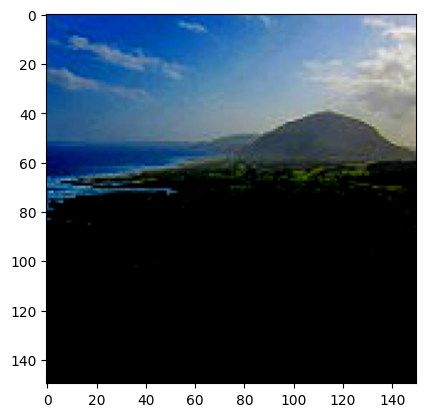

In [59]:
#The 3rd image looks like a mountain
img_np = image_list[2].cpu().numpy().transpose((2, 3, 1, 0))
plt.imshow(img_np.squeeze())
plt.show()

In [60]:
#We are predicting mountain as well, because we have encoded '3' as moutain
results[2]

tensor([3], device='cuda:0')

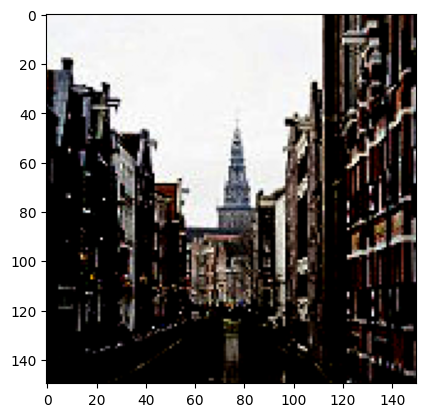

In [68]:
#The 6th image looks like a building
img_np = image_list[5].cpu().numpy().transpose((2, 3, 1, 0))
plt.imshow(img_np.squeeze())
plt.show()

In [69]:
#We are predicting building as well because '0' corresponds to 'building'
results[5]

tensor([0], device='cuda:0')